In [2]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline

import crflux.models as crf
from MCEq.core import config, MCEqRun

import MCEq.geometry.density_profiles as models

from ipywidgets import IntProgress,HTML,HBox
from IPython.display import display

import dask
import earthaccess

h:\Anaconda\envs\mceq_muon\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

| Database Name| Categories | Providing Agency | Access |
| ---------| ---------| ---------| ---------|
| **ERA5** | Reanalysis Data| European Centre for Medium-Range Weather Forecasts(ECMWF) | [Link](https://cds.climate.copernicus.eu) |
| MERRA-2 | Reanalysis Data| NASA | |
| JRA-55 | Reanalysis Data| Japan Meteorological Agency (JMA) |  |
| IGRA | Observational Data| NOAA | [Link](https://www.ncei.noaa.gov/access/weather/igra/) |
| ARM | Observational Data| U.S Department of Energy |  |
| AIRS | Satellite Remote Sensing Data| NASA(Aqua Satellite) | [Link](https://disc.gsfc.nasa.gov/) |
| IASI | Satellite Remote Sensing Data| EUMETSAT(Metop Satellites) |  |

## **MERRA-2** from NASA's earthaccess(py)
Following guide could be helpful

- https://urs.earthdata.nasa.gov/profile
- https://www.earthdata.nasa.gov/data/tools/earthaccess
- https://earthaccess.readthedocs.io/en/latest/

From *github* : **[GES DISC]**
- https://github.com/nasa/gesdisc-tutorials

From *Google Earth Engine Data Catalog* : MERRA-2 Datasets
- https://developers.google.com/earth-engine/datasets/catalog/NASA_GSFC_MERRA_slv_2?hl=zh-cn

`MERRA-2`有多个不同数据集，具体见NASA的`MERRA-2: File Specification`

---

10.17

## M2T1NXSLV

M2T1NXSLV (or tavg1_2d_slv_Nx) is an hourly  **time-averaged**  2-dimensional data collection in Modern-Era Retrospective analysis for Research and Applications version 2 (MERRA-2). This collection consists of meteorology diagnostics at popularly used vertical levels, such as air temperature at 2-meter (or at 10-meter, 850hPa, 500 hPa, 250hPa), wind components at 50-meter (or at 2-meter, 10-meter, 850 hPa, 500hPa, 250 hPa), sea level pressure, surface pressure, and total precipitable water vapor (or ice water, liquid water). The data field is time-stamped with the central time of an hour starting from 00:30 UTC, e.g.: 00:30, 01:30, ... , 23:30 UTC.

MERRA-2 is the latest version of global atmospheric reanalysis for the satellite era produced by NASA Global Modeling and Assimilation Office (GMAO) using the Goddard Earth Observing System Model (GEOS) version 5.12.4. The dataset covers the period of 1980-present with the latency of ~3 weeks after the end of a month.

M2T1NXSLV（或 tavg1_2d_slv_Nx）是现代研究和应用时代回顾性分析版本 2 (MERRA-2) 中的每小时 *时间平均* 二维数据集合。此集合包含常用垂直高度的气象诊断数据，例如 2 米（或 10 米、850 hPa、500 hPa、250 hPa）高度的气温、50 米（或 2 米、10 米、850 hPa、500 hPa、250 hPa）高度的风分量、海平面气压、地面气压和总可降水水汽（或冰水、液态水）。数据字段的时间戳为从 00:30 UTC 开始的小时的中心时间，例如：00:30、01:30、...、23:30（世界协调时间）。

MERRA-2 是 NASA 全球建模与同化办公室 (GMAO) 使用 Goddard 地球观测系统模型 (GEOS) 版本 5.12.4 制作的最新版卫星时代全球大气再分析数据。该数据集涵盖 1980 年至今的时期，延迟时间约为一个月结束后的 3 周。

从`Earthaccess`导入`[M2T1NXSLV]`数据集

In [3]:
auth = earthaccess.login(strategy="environment")

# To download multiple files, change the second temporal parameter
results = earthaccess.search_data(
    short_name="M2T1NXSLV",
    version='5.12.4',
    temporal=('2025-05-01', '2025-05-02'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(-180, 0, 180, 90)
)

files = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
ds = xr.open_mfdataset(
    files,
    engine='h5netcdf'
    )

print("数据集变量:", list(ds.data_vars.keys()))
print("数据集坐标:", list(ds.coords.keys()))

数据集变量: ['CLDPRS', 'CLDTMP', 'DISPH', 'H1000', 'H250', 'H500', 'H850', 'OMEGA500', 'PBLTOP', 'PS', 'Q250', 'Q500', 'Q850', 'QV10M', 'QV2M', 'SLP', 'T10M', 'T250', 'T2M', 'T2MDEW', 'T2MWET', 'T500', 'T850', 'TO3', 'TOX', 'TQI', 'TQL', 'TQV', 'TROPPB', 'TROPPT', 'TROPPV', 'TROPQ', 'TROPT', 'TS', 'U10M', 'U250', 'U2M', 'U500', 'U50M', 'U850', 'V10M', 'V250', 'V2M', 'V500', 'V50M', 'V850', 'ZLCL']
数据集坐标: ['lon', 'lat', 'time']


From EEDC: 截取一些`[M2T1NXSLV]`的数据名
| 名称      | 单位        | 像元大小 | 说明                                       |
|-----------|-------------|----------|--------------------------------------------|
| CLDPRS    | Pa          | 米       | 云顶压力                                   |
| CLDTMP    | K           | 米       | 云顶温度                                   |
| H1000     | 米          | 米       | 1000 mb 时的高度                           |
| H250      | 米          | 米       | 250 hPa 时的海拔高度                       |
| H500      | 米          | 米       | 500 hPa 处的高度                           |
| H850      | 米          | 米       | 850 hPa 时的高度                           |
| OMEGA500  | Pa/s        | 米       | 500 hPa 时的 Omega                         |
| PBLTOP    | Pa          | 米       | Pbltop 压力                                |
| PS        | Pa          | 米       | 表面压力                                   |
| SLP       | Pa          | 米       | 海平面气压                                 |
| T10M      | K           | 米       | 10 米气温                                  |
| T250      | K           | 米       | 250 hPa 时的气温                           |
| T2MDEW    | K           | 米       | 2 米处的温度                               |
| T2MWET    | K           | 米       | 2 米处的湿球温度                           |
| T2M       | K           | 米       | 2 米高度的气温                             |
| T500      | K           | 米       | 500 hPa 时的气温                           |
| T850      | K           | 米       | 850 hPa 时的气温                           |
| TROPPB    | Pa          | 米       | 基于混合估计值的对流层顶气压 (TROPP)        |
| TROPPT    | Pa          | 米       | 基于热力学估计的对流层顶气压               |
| TROPPV    | Pa          | 米       | 基于 epv 估计值的对流层顶压力              |
| TROPT     | K           | 米       | 使用混合对流层顶估计值的对流层顶温度       |
| TS        | K           | 米       | 表层皮肤温度                               |

In [3]:
#地理轮廓线
coastline = cfeature.COASTLINE
borders = cfeature.BORDERS
land = cfeature.LAND
ocean = cfeature.OCEAN

### Daya Bay

| EH | longitude | latitude | rock coverage | altitude|
|----|-----|----|----|----|
|EH1 | 114.545072 | 22.600338| 93m  |-21.79m |
|EH2 | 114.548871 | 22.608738| 100m |  4.44m |
|EH3 | 114.540537 | 22.614854| 324m  | 10.07m |

地点数据
locations = {
    'EH1': {'lon': 114.545072, 'lat': 22.600338, 'rock': '93m', 'alt': '-21.79m'},
    'EH2': {'lon': 114.548871, 'lat': 22.608738, 'rock': '100m', 'alt': '4.44m'},
    'EH3': {'lon': 114.540537, 'lat': 22.614854, 'rock': '324m', 'alt': '10.07m'}
}

标注地点
for name, loc in locations.items():

绘制地点标记
ax.plot(loc['lon'], loc['lat'], 'ro', markersize=8, transform=ccrs.PlateCarree())
        
添加地点标签
ax.text(loc['lon'] + 0.1, loc['lat'] + 0.1, name, 
        fontsize=12, weight='bold', color='red',
        transform=ccrs.PlateCarree())
        
添加详细信息（岩石覆盖和海拔）
ax.text(loc['lon'] + 0.1, loc['lat'] - 0.1, 
        f"Rock: {loc['rock']}\nAlt: {loc['alt']}", 
        fontsize=9, color='darkred',
        transform=ccrs.PlateCarree())

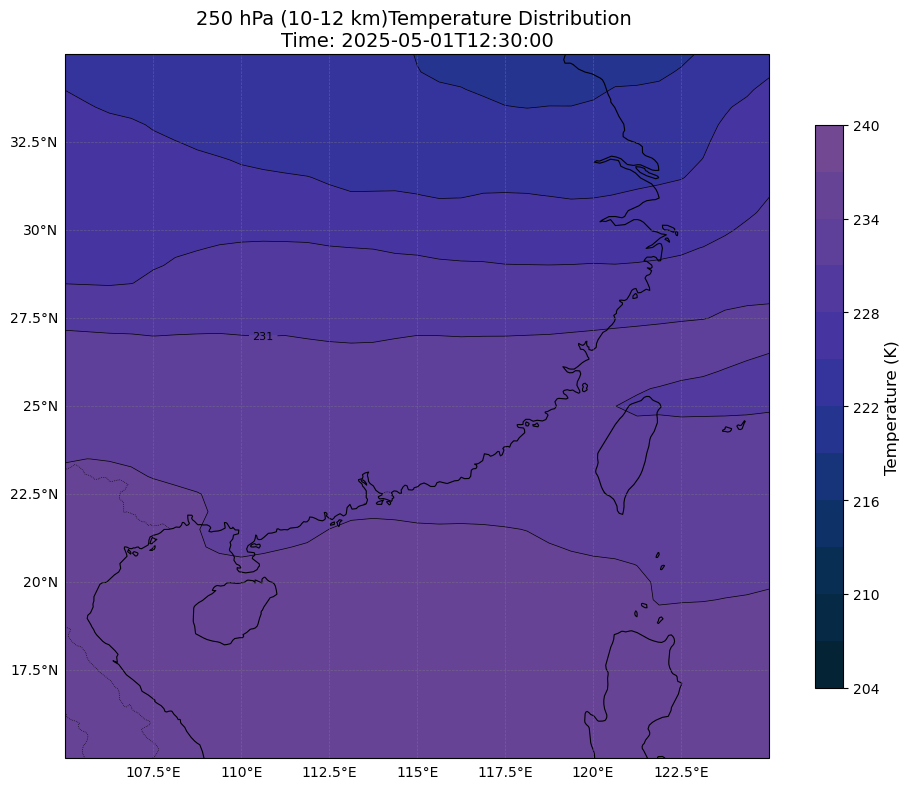

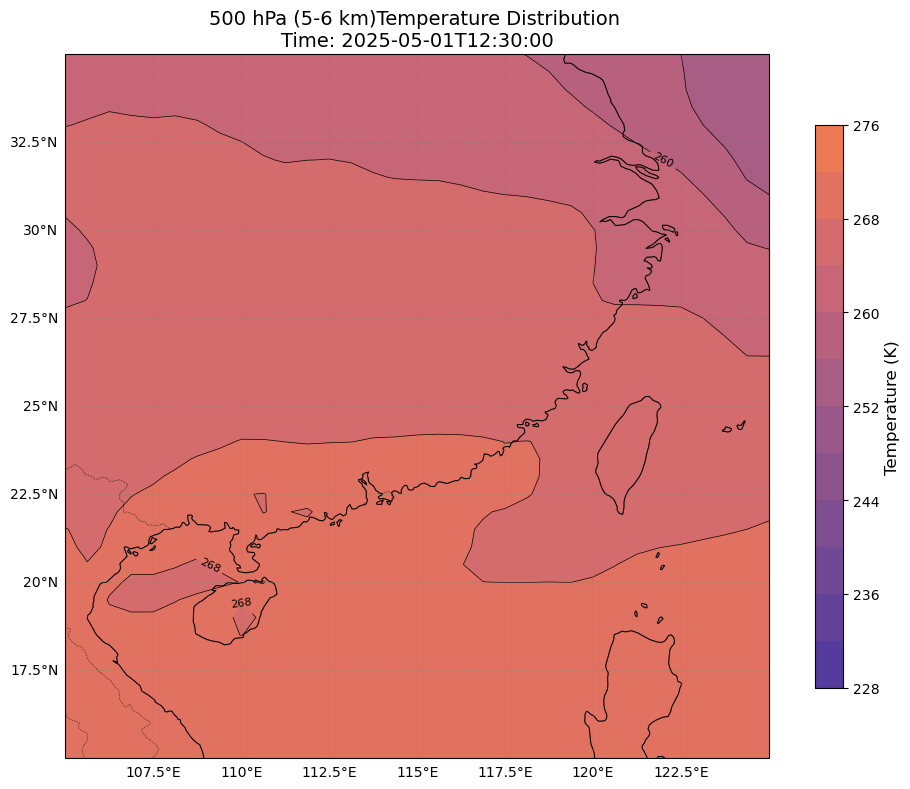

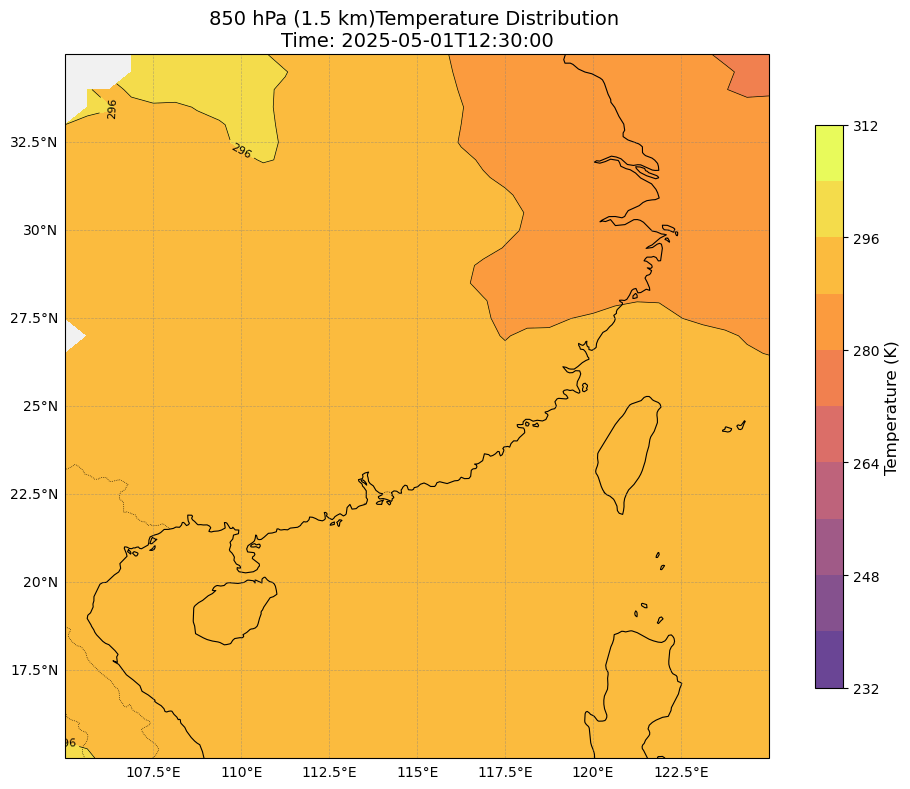

In [14]:
# 选择要可视化的气压层
pressure_levels = ['T250', 'T500', 'T850']
pressure_titles = {
    'T250': '250 hPa (10-12 km)',
    'T500': '500 hPa (5-6 km)',
    'T850': '850 hPa (1.5 km)'
}

# 选择时间点 - 使用 12:30
time_idx = 12
time_str = str(ds.time.isel(time=time_idx).values)[:19]

# 检查哪些气压层变量存在
available_levels = [var for var in pressure_levels if var in ds.data_vars]

# 为所有子图设置统一的最小和最大温度值，确保颜色条一致
vmin = min([ds[level].min().values for level in available_levels])
vmax = max([ds[level].max().values for level in available_levels])

# 分别绘制每个气压层的温度分布图
for level in available_levels:
    # 创建新图形
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # 获取该气压层的温度数据
    temp_data = ds[level].isel(time=time_idx)
    
    # 设置地图范围
    ax.set_extent([105, 125, 15, 35], crs=ccrs.PlateCarree())
    
    # 绘制温度分布
    contour = ax.contourf(
        temp_data.lon, temp_data.lat, temp_data,
        levels=10, 
        vmin=vmin, vmax=vmax,
        cmap='cmo.thermal',  # 使用海洋学颜色映射
        transform=ccrs.PlateCarree()
    )
    
    # 添加等高线
    contour_lines = ax.contour(
        temp_data.lon, temp_data.lat, temp_data,
        levels=10,
        colors='black',
        linewidths=0.5,
        transform=ccrs.PlateCarree()
    )
    
    # 添加等高线标签
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%1.0f')

    # 添加地理特征
    ax.add_feature(coastline, linewidth=0.8, edgecolor='black')
    ax.add_feature(borders, linestyle=':', linewidth=0.5)
    ax.add_feature(land, facecolor='lightgray', alpha=0.3)
    ax.add_feature(ocean, facecolor='lightblue', alpha=0.3)
    
    # 添加网格线
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    cbar = plt.colorbar(contour, ax=ax, shrink=0.8)
    cbar.set_label(f"Temperature ({ds[level].attrs.get('units', 'K')})", fontsize=12)
    
    plt.title(f"{pressure_titles[level]}Temperature Distribution \nTime: {time_str}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

---

10.23

## M2I3NPASM
https://registry.opendata.aws/nasa-m2i3npasm/

MERRA-2 **inst3_3d_asm_Np**: 
- 3d,3-Hourly,Instantaneous,Pressure-Level,Assimilation,Assimilated Meteorological Fields 0.625 x 0.5 degree V5.12.4 (M2I3NPASM) at GES DISC.

M2I3NPASM (or inst3_3d_asm_Np) is an instantaneous 3-dimensional 3-hourly data collection in Modern-Era Retrospective analysis for Research and Applications version 2 (MERRA-2). This collection consists of assimilations of meteorological parameters at 42 pressure levels, such as temperature, wind components, vertical pressure velocity, water vapor, ozone mass mixing ratio, and layer height. The data field is available every three hours starting from 00:00 UTC, e.g.: 00:00, 03:00, … , 21:00 UTC. The information on the pressure levels can be found in the section 4.2 of the MERRA-2 File Specification document. MERRA-2 is the latest version of global atmospheric reanalysis for the satellite era produced by NASA Global Modeling and Assimilation Office (GMAO) using the Goddard Earth Observing System Model (GEOS) version 5.12.4. The dataset covers the period of 1980-present with the latency of ~3 weeks after the end of a month. Data Reprocessing: Please check “Records of MERRA-2 Data Reprocessing and Service Changes” linked from the “Documentation” tab on this page. Note that a reprocessed data filename is different from the original file.

M2I3NPASM（或inst3_3d_asm_Np）是现代年代再分析研究与应用版本2（MERRA-2）中即时三维三小时数据集。该数据集包含42个气压层的气象参数同化结果，包括温度、风向分量、垂直压力速度、水汽、臭氧质量混合比及层高。数据场以三小时为间隔更新，起始于协调世界时00:00，例如：00:00、03:00、…、21:00。各气压层信息详见MERRA-2文件规范文档第4.2节。MERRA-2是由美国宇航局全球模型与同化办公室（GMAO）基于戈达德地球观测系统模型（GEOS）5.12.4版构建的卫星时代最新全球大气再分析数据集。该数据集覆盖1980年至今的观测期，每月数据发布滞后约3周。数据重处理：请查阅本页面“文档”标签页链接的《MERRA-2数据重处理与服务变更记录》。请注意：再处理后的数据文件名与原始文件不同。

但这并不好，因为是瞬态数据，我们更需要平均数据

## M2T3NVASM
https://data.nasa.gov/dataset/merra-2-tavg3-3d-asm-nv-3d3-hourlytime-averagedmodel-levelassimilationassimilated-meteorol-3a2e0

DOI:10.5067/SUOQESM06LPK

MERRA-2 **tavg3_3d_asm_Nv**: 
- 3d,3-Hourly,Time-Averaged,Model-Level,Assimilation,Assimilated Meteorological Fields 0.625 x 0.5 degree V5.12.4 (M2T3NVASM) at GES DISC
- 基本与*M2I3NPASM*类似，但是数据是**三小时平均值**

M2T3NVASM（或tavg3_3d_asm_Nv）是现代时期再分析数据集第2版（MERRA-2）中一项三维三小时平均数据集。该数据集包含72个模型层的气象参数同化结果，如气温、风向分量、垂直压力速度、水汽含量及层高。数据字段自协调世界时01:30起每三小时更新一次，例如：01:30、04:30、…、22:30。MERRA-2文件规范文档第4.2节给出了以1000百帕地面气压为基准的压力值，该值对应层顶边界。lev=1代表顶层，lev=72代表底层（或地面）模型层。

最高层85 km

In [4]:
auth = earthaccess.login(strategy="environment")

# To download multiple files, change the second temporal parameter
results = earthaccess.search_data(
    short_name="M2T3NVASM",
    version='5.12.4',
    temporal=('2025-05-01', '2025-05-01'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(105, 15, 125, 35)
)

files = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
ds = xr.open_mfdataset(
    files,
    engine='h5netcdf'
    )

print("数据集变量:", list(ds.data_vars.keys()))
print("数据集坐标:", list(ds.coords.keys()))

数据集变量: ['CLOUD', 'DELP', 'EPV', 'H', 'O3', 'OMEGA', 'PHIS', 'PL', 'PS', 'QI', 'QL', 'QV', 'RH', 'SLP', 'T', 'U', 'V']
数据集坐标: ['lon', 'lat', 'lev', 'time']


| 变量名 | 维度 | 描述 | 单位 |
|------|------|-------------|-------|
| CLOUD | tzyx | 辐射云量 | 1 (无量纲) |
| <font color="red">DELP</font> | tzyx | 气压厚度 | 帕斯卡 (Pa) |
| EPV | tzyx | 埃特尔位势涡度 | 开尔文·平方米/千克·秒 (K m² kg⁻¹ s⁻¹) |
| <font color="red">H</font> | tzyx | 中间层高度 | 米 (m) |
| O3 | tzyx | 臭氧质量混合比 | 千克/千克 (kg/kg) |
| OMEGA | tzyx | 垂直气压速度 | 帕斯卡/秒 (Pa/s) |
| PHIS | tyx | 地表位势高度 | 平方米/平方秒 (m²/s²) |
| <font color="red">PL</font> | tzyx | 中间层气压 | 帕斯卡 (Pa) |
| <font color="red">PS</font> | tyx | 地表气压 | 帕斯卡 (Pa) |
| QI | tzyx | 云冰水质量分数 | 千克/千克 (kg/kg) |
| QL | tzyx | 云液态水质量分数 | 千克/千克 (kg/kg) |
| <font color="red">QV</font> | tzyx | 比湿 | 千克/千克 (kg/kg) |
| RH | tzyx | 湿过程后相对湿度 | 1 (无量纲) |
| SLP | tyx | 海平面气压 | 帕斯卡 (Pa) |
| <font color="red">T</font> | tzyx | 气温 | 开尔文 (K) |
| U | tzyx | 东风（向东风速） | 米/秒 (m/s) |
| V | tzyx | 北风（向北风速） | 米/秒 (m/s) |

In [6]:
print(ds['H'])

<xarray.DataArray 'H' (time: 8, lev: 72, lat: 361, lon: 576)> Size: 479MB
dask.array<open_dataset-H, shape=(8, 72, 361, 576), dtype=float32, chunksize=(1, 1, 91, 144), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 576B 1.0 2.0 3.0 4.0 5.0 ... 68.0 69.0 70.0 71.0 72.0
  * time     (time) datetime64[ns] 64B 2025-05-01T01:30:00 ... 2025-05-01T22:...
Attributes:
    long_name:       mid_layer_heights
    units:           m
    fmissing_value:  1e+15
    standard_name:   mid_layer_heights
    vmax:            1e+15
    vmin:            -1e+15
    valid_range:     [-1.e+15  1.e+15]


总共72层数据：
1. 计算各层压强：从模型顶部开始累积DELP得到各层底部的压强，模型顶部压强 $P_{TOP} = 0.01 hPa = 1 Pa$
   
   垂直坐标：从顶层(1)到底层(72)

   计算各层顶部压强和底部压强：第一层顶部就是PTOP，其他层顶部是上一层的底部；每一层底部与顶部差值由`DELP`给出

   层平均压强：
   $$
   P_{mid}=\sqrt{P_{TOP}\times P_{Bottom}}
   $$

2. 计算虚温 (考虑水汽影响): 在相同气压下，干空气密度与实际湿空气密度相同时，干空气应该具有的温度.由于湿空气的气体常数 $R_m$ 随水汽含量变化，使用不便。引入虚温后就可以用干空气气体常数来处理湿空气问题
$$
T_v = T \times (1 + 0.608QV)
$$
3. 计算大气密度
$$
\rho = \frac{P}{R_d \cdot T_v}
$$

In [ ]:
# 选择需要的变量
# T: 温度(K), DELP: 气压厚度(Pa), QV: 比湿(kg/kg), PS: 地表气压(Pa)
variables = ['T', 'DELP', 'QV', 'PS']
ds_subset = ds[variables]

# 计算72层垂直剖面的平均
def calculate_vertical_profiles(ds):
    """计算垂直剖面的温度、压强和密度"""
    
    # 1. 计算各层压强
    PTOP = 1.0  # Pa
    
    # 计算各层底部压强
    # 注意：MERRA-2垂直坐标是从顶层(1)到底层(72)
    pressure_bottom = PTOP + ds['DELP'].cumsum(dim='lev')
    
    # 计算各层顶部压强
    pressure_top = pressure_bottom.shift(lev=1, fill_value=PTOP)
    
    # 层平均压强 (对数平均更准确)
    pressure_mid = np.sqrt(pressure_top * pressure_bottom)
    
    # 2. 计算虚温 (考虑水汽影响)
    # T_v = T * (1 + 0.608 * QV)
    virtual_temp = ds['T'] * (1 + 0.608 * ds['QV'])
    
    # 3. 计算大气密度 (kg/m³)
    # ρ = P / (R_d * T_v)
    R_d = 287.05  # 干空气气体常数 J/(kg·K)
    density = pressure_mid / (R_d * virtual_temp)
    
    # 创建包含所有结果的数据集
    result_ds = xr.Dataset({
        'temperature': ds['T'],           # 温度 (K)
        'pressure': pressure_mid,         # 压强 (Pa)
        'density': density,               # 密度 (kg/m³)
        'virtual_temperature': virtual_temp  # 虚温 (K)
    })
    
    return result_ds

# 计算垂直剖面
profiles = calculate_vertical_profiles(ds_subset)

# 计算整个时间段和区域的平均垂直剖面
# 先对时间和水平维度求平均，保留垂直维度
mean_profiles = profiles.mean(dim=['time', 'lon', 'lat'], keep_attrs=True)

# MERRA-2提供了H变量表示高度
height_mean = ds['H'].mean(dim=['time', 'lon', 'lat'])
mean_profiles['height'] = height_mean

print("垂直剖面平均计算完成")
print(f"垂直层数: {len(mean_profiles.lev)}")
print(f"温度范围: {mean_profiles['temperature'].min().values:.2f} - {mean_profiles['temperature'].max().values:.2f} K")
print(f"压强范围: {mean_profiles['pressure'].min().values:.2f} - {mean_profiles['pressure'].max().values:.2f} Pa")
print(f"密度范围: {mean_profiles['density'].min().values:.6f} - {mean_profiles['density'].max().values:.6f} kg/m³")

# 将结果转换为更易读的单位
mean_profiles_readable = xr.Dataset({
    'temperature_c': mean_profiles['temperature'] - 273.15,  # 转换为摄氏度
    'pressure_hpa': mean_profiles['pressure'] / 100,          # 转换为hPa
    'density': mean_profiles['density']                       # 保持kg/m³
})

# 打印每层的结果（前10层示例）
print("\n前10层平均结果:")
for i in range(min(10, len(mean_profiles.lev))):
    lev = mean_profiles.lev[i].values
    temp = mean_profiles_readable['temperature_c'].sel(lev=lev).values
    pres = mean_profiles_readable['pressure_hpa'].sel(lev=lev).values
    dens = mean_profiles_readable['density'].sel(lev=lev).values
    
    print(f"层 {int(lev):2d}: 温度={temp:6.2f}°C, 压强={pres:7.2f} hPa, 密度={dens:.5f} kg/m³")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
    
    # 温度剖面
ax1.semilogy(mean_profiles['temperature'], mean_profiles['pressure']/100)
ax1.set_xlabel('温度 (K)')
ax1.set_ylabel('压强 (hPa)')
ax1.set_title('温度垂直剖面')
ax1.grid(True)
    
    # 压强剖面（对数坐标）
ax2.semilogy(mean_profiles['pressure']/100, mean_profiles['pressure']/100)
ax2.set_xlabel('压强 (hPa)')
ax2.set_ylabel('压强 (hPa)')
ax2.set_title('压强垂直分布')
ax2.grid(True)
    
    # 密度剖面
ax3.semilogy(mean_profiles['density'], mean_profiles['pressure']/100)
ax3.set_xlabel('密度 (kg/m³)')
ax3.set_ylabel('压强 (hPa)')
ax3.set_title('密度垂直剖面')
ax3.grid(True)
    
plt.tight_layout()
plt.savefig('vertical_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

# 关闭文件连接
files.close()

垂直剖面平均计算完成
垂直层数: 72
温度范围: 200.72 - 279.08 K
压强范围: 1.41 - 95935.47 Pa
